# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from agent import DDPGAgent
import argparse, sys
import time

9.2
Quadro M2000M
cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='C:/Users/anshmish/Desktop/Personal/Courses/DRLND/deep-reinforcement-learning/p2_continuous-control/Reacher_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 20
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


### 3. Train the Agent

In [5]:
def trainAgent(agent, n_episodes=400, timeout=1000, score_window_size=100, solution_score=30):
    print('\nTraining agent ')
    scores = []                                                 # list containing scores from each episode
    scores_window = deque(maxlen=score_window_size)             # last 'score_window_size' scores for candidate solution

    for episode in range(n_episodes):
        start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
        states = env_info.vector_observations                   # get the current state(s)
        ep_scores = np.zeros(n_agents)
        agent.reset()

        for t in range(timeout):
            # t_start = time.time()
            # Query agent for actions
            actions = agent.act(states)

            # t_agent_action = time.time()
            env_info = env.step(actions)[brain_name]             # send the action to the environment and get feedback
            # t_env_step = time.time()

            next_states = env_info.vector_observations           # get the next state
            rewards = env_info.rewards                           # get the reward
            dones = env_info.local_done                          # see if episode has finished

            # Move the agent a step
            # t_env_obs = time.time()
            agent.step(states, actions, rewards, next_states, dones)

            ep_scores += np.array(rewards)                       # update the score(s)
            states = next_states                                 # updates the state(s)

            # t_end = time.time()

            # print('\rStep: {:d}\tGet Action: {:.3f}\tEnv Action: {:.3f}\tAgent Step: {:.3f}\tTotal: {:.3f}'.format(t,t_agent_action-t_start, t_env_step-t_agent_action, t_end-t_env_obs, t_end-t_start), end="")

            if np.any(dones):                                    # exit loop if any of the episodes finished
                break
        
        # Cache the score(s)
        # print(ep_scores)
        scores.append(np.mean(ep_scores))
        scores_window.append(np.mean(ep_scores))

        episode_time = time.time()-start_time

        # Print episode results
        print('\rEpisode {}\ttime: {:.3f}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(episode, episode_time, np.mean(ep_scores), np.mean(scores_window)), end="")

        # Print if solution score achieved
        if np.mean(scores_window)>=solution_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(episode-100, np.mean(scores_window)))
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            break
    
    print("\nTraining Completed!")
    return scores

In [6]:
agent = DDPGAgent(state_size=state_size, action_size=action_size, n_agents=n_agents, seed=48)
scores = trainAgent (agent, n_episodes=1000)


Training agent 
Episode 351	time: 31.537	Score: 34.28	Average Score: 30.04
Environment solved in 251 episodes!	Average Score: 30.04


Training Completed!


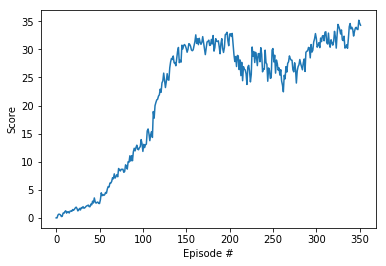

In [7]:
def plotScores(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

plotScores(scores)

### 4. Test the Agent

In [8]:
def testAgent():
    print("Testing the Agent")
    agent = DDPGAgent(state_size=state_size, action_size=action_size, n_agents=n_agents, seed=0, pretrainedWeightsFile='checkpoint_actor.pth', train = False)
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment
    states = env_info.vector_observations                   # get the current state
    score = np.zeros(n_agents)                              # initialize the score
    while True:
        actions = agent.act(states)                         # select an action
        env_info = env.step(actions)[brain_name]            # send the action to the environment
        next_states = env_info.vector_observations          # get the next state
        rewards = env_info.rewards                          # get the reward
        dones = env_info.local_done                         # see if episode has finished
        score += np.array(rewards)                          # update the score
        states = next_states                                # roll over the state to next time step
        if np.any(dones):                                   # exit loop if episode finished
            break
    print("Score: {}".format(np.mean(score)))
    return score

In [9]:
testAgent()

Testing the Agent
Score: 32.9829992627725


array([39.01999913, 39.54999912, 29.05999935, 39.36999912, 34.05999924,
       27.27999939, 36.42999919, 37.43999916, 32.11999928, 34.84999922,
       38.72999913, 32.75999927, 20.88999953, 39.31999912, 31.75999929,
       31.97999929, 35.9599992 , 28.33999937, 26.03999942, 24.69999945])

In [10]:
env.close()